In [ ]:
import re

BIODIVERSITY_PATTERN = re.compile(r"biodiversity of (\d+) unique species")
STDOUT_FILE_PATTERN = re.compile(r"stdout_([^_]+)_([^_]+)_([^_]+)_([^_]+)_([^_]+)_(.+)\.txt")

In [2]:
import numpy as np
from scipy import stats
from matplotlib import pyplot as plt
import os
from collections import defaultdict
from pathlib import Path
import scipy.special as sp
from itertools import product
from scipy.stats import norm

In [3]:
def preston(A_on_sigma_sq, nu):
    a = np.sqrt(A_on_sigma_sq / np.pi)
    
    nu_eff = nu * np.log(1.0 / nu) / (1.0 - nu)
    
    num = 2.0 * np.pi * a * (1.0 - nu_eff) * sp.i1e(a)
    
    denom = (1.0 / np.sqrt(nu_eff)) * sp.i1e(a) * sp.k0e(np.sqrt(nu_eff) * a) / sp.k1e(np.sqrt(nu_eff) * a) + sp.i0e(a)
    
    return (nu_eff * A_on_sigma_sq + num / denom)

def s_contig(A_eff, deme, nu, sigma_sq):
    return sigma_sq * preston(A_eff * deme / sigma_sq, nu)

def s_island(A_eff, deme, nu):
    theta_A_eff = (deme * A_eff - 1.0) * nu / (1.0 - nu)
    
    return theta_A_eff * (sp.digamma(theta_A_eff + deme * A_eff) - sp.digamma(theta_A_eff))

def s_island_limit(A_eff, deme, nu):
    return ((A_eff * deme - 1.0) * nu * np.log(1.0 / nu)) / (1.0 - nu)

In [4]:
biodiversities = defaultdict(dict)

for root, dirs, files in os.walk("output"):
    root = Path(root)
    
    for file in files:
        match = STDOUT_FILE_PATTERN.match(file)
        
        if match is None:
            continue
        
        algorithm = match.group(1)
        seed = int(match.group(2))
        spec = float(match.group(3))
        sample = float(match.group(4))
        radius = int(match.group(5))
        sigma = float(match.group(6))
        
        with open(root / file, 'r') as file:
            biodiversities[(algorithm, spec, sample, radius, sigma)][seed] = int(BIODIVERSITY_PATTERN.search(file.read()).group(1))
    
    break

biodiversities = dict(sorted(biodiversities.items(), key=lambda kv: kv[0][::-1]))

In [5]:
def confidenceInterval(a, conf=0.95):
    mean = np.mean(a)
    sem = stats.sem(a)
    
    t = stats.t.ppf((1.0 + conf) * 0.5, len(a) - 1)
    
    return mean - t*sem, mean + t*sem

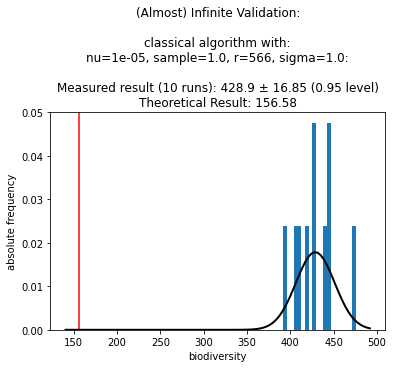

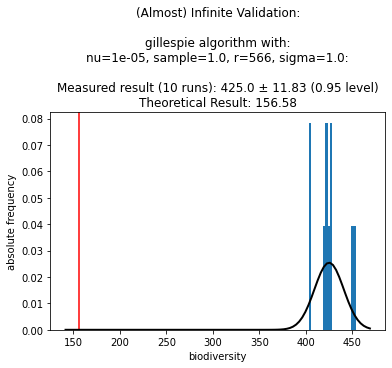

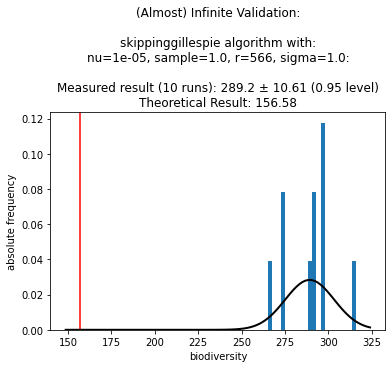

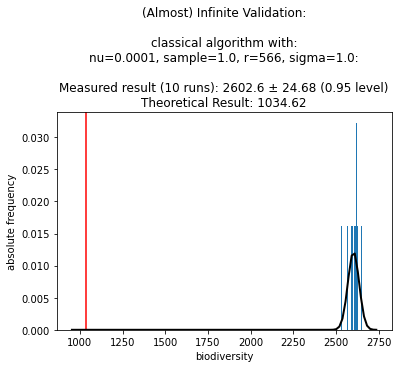

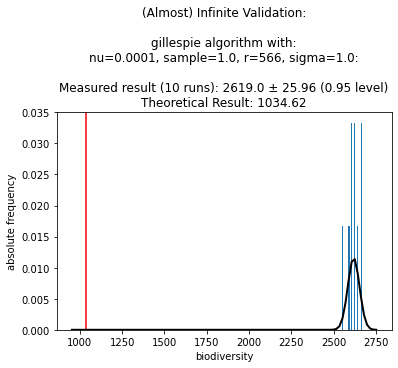

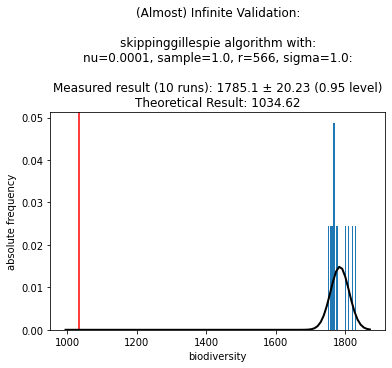

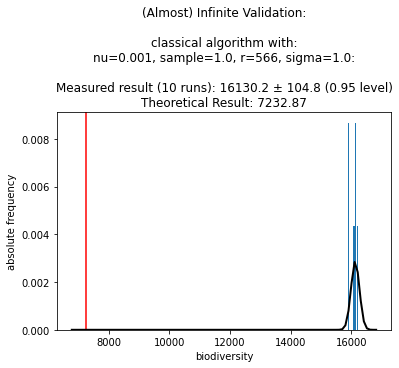

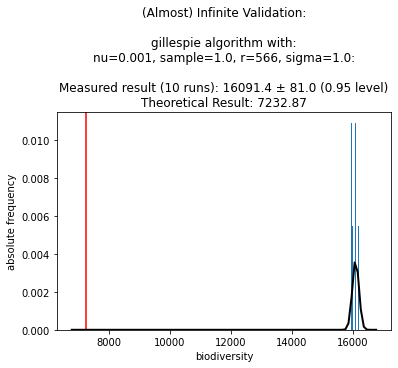

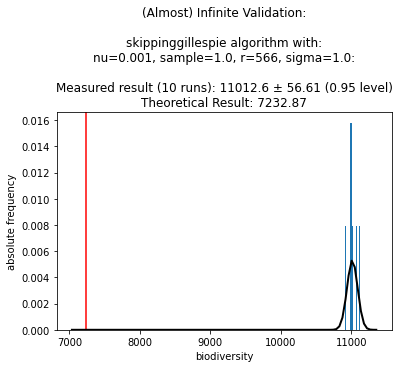

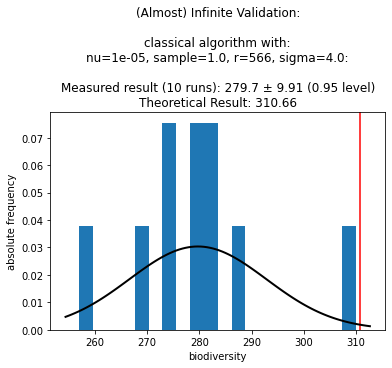

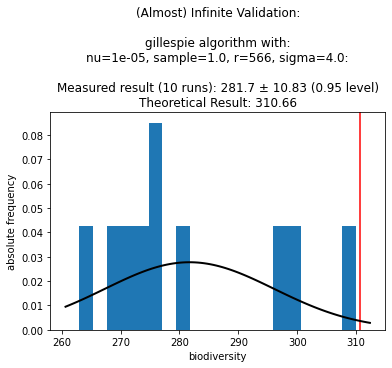

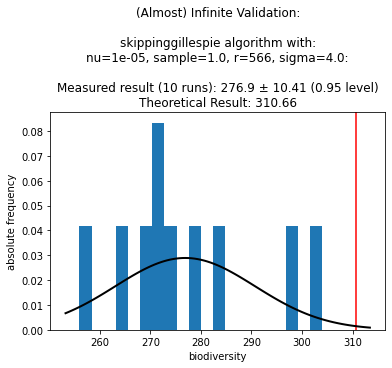

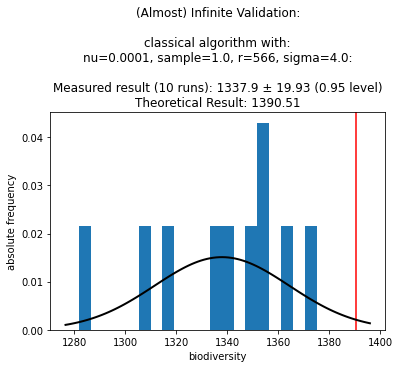

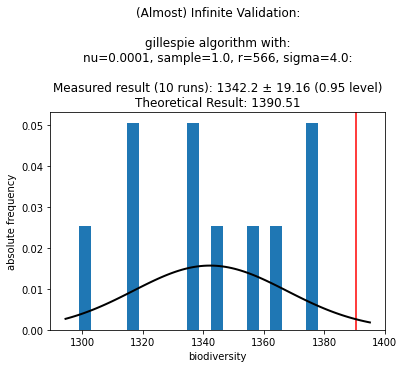

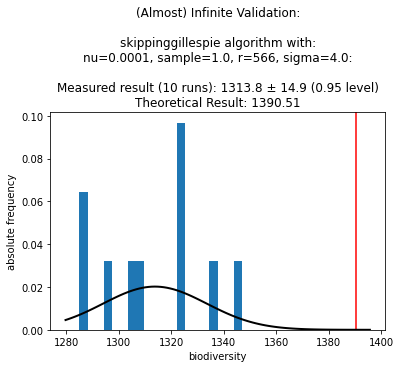

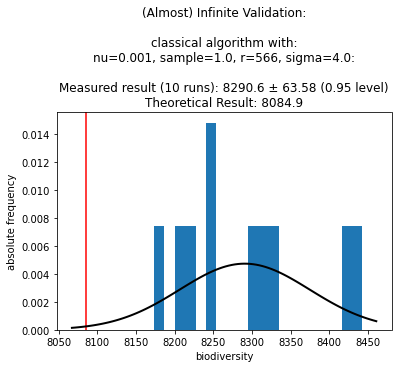

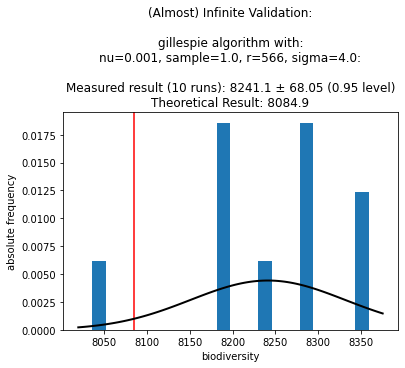

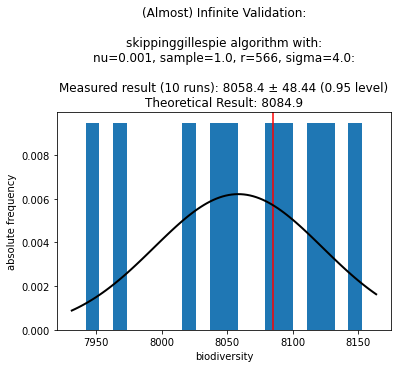

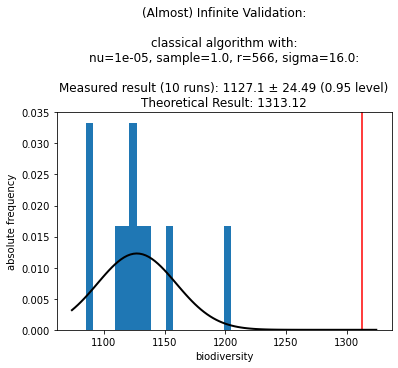

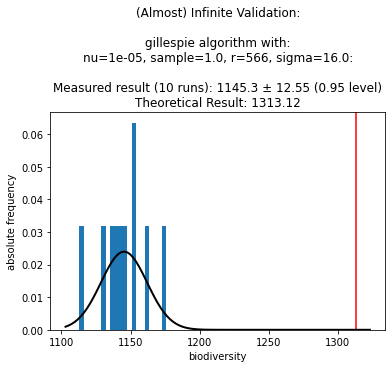

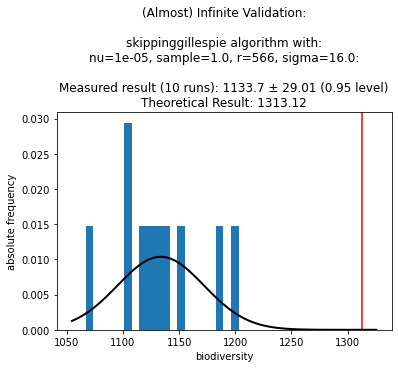

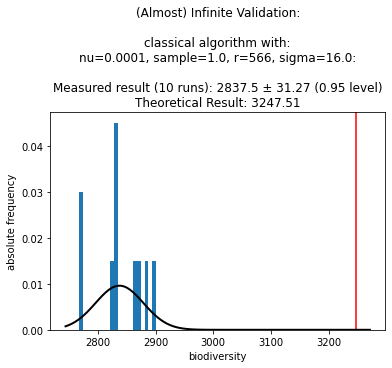

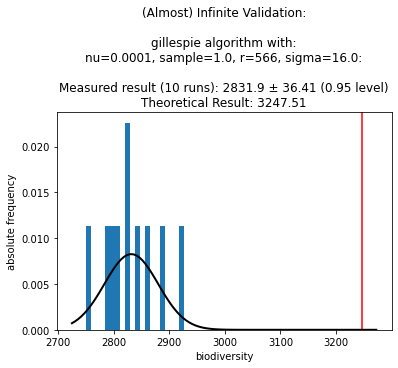

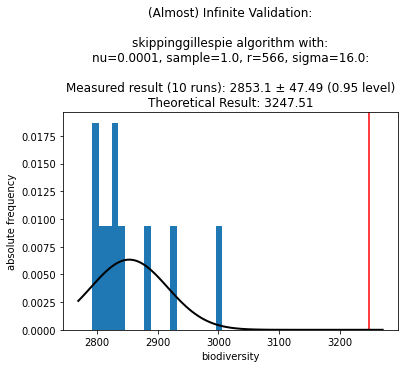

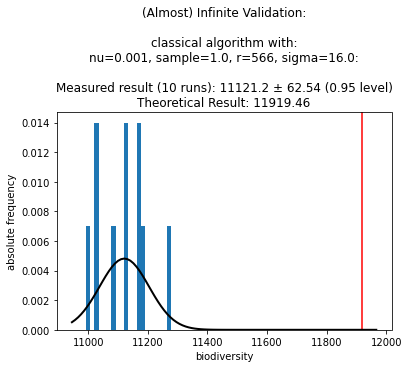

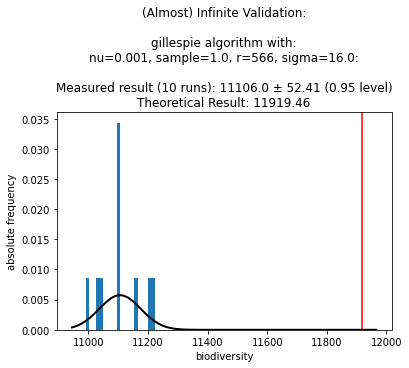

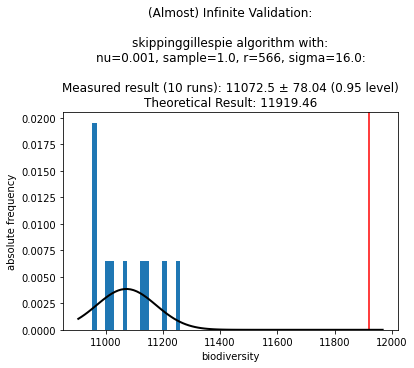

In [6]:
conf = 0.95

for key, values in biodiversities.items():
    values = tuple(values.values())
    
    low, high = confidenceInterval(values)
    
    algorithm, spec, sample, radius, sigma = key
    
    minval = np.min(values)
    maxval = np.max(values)
    
    plt.title("(Almost) Infinite Validation:\n\n"
              + f"{algorithm} algorithm with:\nnu={spec}, sample={sample}, r={radius}, sigma={sigma}:\n\n"
              + f"Measured result ({len(values)} runs): {round((low + high) * 0.5, 2)} ± "
              + f"{round((high - low) * 0.5, 2)} ({conf} level)\nTheoretical Result: "
              + f"{round(s_contig(radius * radius * np.pi, 1, spec, sigma * sigma), 2)}"
             )
    plt.xlabel("biodiversity")
    plt.ylabel("absolute frequency")
    plt.hist(values, bins = min(20, maxval - minval + 1), density=True)
    plt.axvline(x=s_contig(radius * radius * np.pi, 1, spec, sigma * sigma), color='red')

    mu, std = norm.fit(values)
    xmin, xmax = plt.xlim()
    x = np.linspace(xmin, xmax, 100)
    p = norm.pdf(x, mu, std)
    plt.plot(x, p, 'k', linewidth=2)
    
    plt.show()